In [1]:
# ==============================
# Setup: Spark Session & Data Load
# ==============================
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, to_date, count, avg, date_format

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Start Spark session
spark = SparkSession.builder.appName("SIT742Assignment2").getOrCreate()

# Load CSVs
# reviews = spark.read.csv("./business_review_submission/review.csv", header=True, inferSchema=True)
# meta = spark.read.csv("./business_review_submission/meta-review-business.csv", header=True, inferSchema=True)

reviews = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .option("multiLine", "true")         # handles reviews spanning multiple lines
    .option("escape", "\"")              # handles quotes in text
    .option("mode", "PERMISSIVE")        # keep malformed rows instead of dropping
    .option("columnNameOfCorruptRecord", "_corrupt_record")  # optional: track bad rows
    .load("./business_review_submission/review.csv")
)

meta = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .option("mode", "PERMISSIVE")
    .load("./business_review_submission/meta-review-business.csv")
)

# Preview
reviews.printSchema()
meta.printSchema()


root
 |-- user_id: double (nullable = true)
 |-- name: string (nullable = true)
 |-- time: long (nullable = true)
 |-- rating: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)

root
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- gmap_id: string (nullable = true)
 |-- description: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- category: string (nullable = true)
 |-- avg_rating: string (nullable = true)
 |-- num_of_reviews: string (nullable = true)
 |-- price: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- MISC: string (nullable = true)
 |-- state: string (nullable = true)
 |-- relative_results: string (nullable = true)
 |-- url: string (nullable = true)



### Q1.1

In [2]:
from pyspark.sql.functions import col, when, from_unixtime

# Replace null text with "no review"
reviews = reviews.withColumn("text", when(col("text").isNull(), "no review").otherwise(col("text")))

# Convert Unix timestamp (milliseconds) into yyyy-MM-dd
reviews = reviews.withColumn("newtime", from_unixtime((col("time")/1000).cast("bigint"), "yyyy-MM-dd"))

# Show first 5 rows
reviews.select("user_id", "name", "time", "newtime", "rating", "text", "gmap_id").show(5, truncate=False)


+---------------------+-----------------+-------------+----------+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------+
|user_id              |name             |time         |newtime   |rating|text                                                                  

### Q1.2

In [3]:
from pyspark.sql.functions import count

# Count number of reviews per gmap_id
review_counts = reviews.groupBy("gmap_id") \
    .agg(count("*").cast("float").alias("review_count"))

# Show top 5 rows
review_counts.show(5, truncate=False)


+-------------------------------------+------------+
|gmap_id                              |review_count|
+-------------------------------------+------------+
|0x56c8977642a793f5:0xab9f95aa9c585a46|27.0        |
|0x56c79c63a5af15e3:0x117ca44b9578b995|10.0        |
|0x56c8976e16705e63:0x787e5d94ea9d2387|49.0        |
|0x51325aac7a4434e5:0xfbed5197982b41ae|28.0        |
|0x56c6631e32190947:0x7620b39117ffbb62|12.0        |
+-------------------------------------+------------+
only showing top 5 rows



In [4]:
import pandas as pd

# Convert Spark DataFrame into Pandas
pdf = reviews.select("gmap_id", "time", "newtime", "text", "rating").toPandas()

# Convert Unix time (ms) into datetime
pdf["datetime"] = pd.to_datetime(pdf["time"], unit="ms", errors="coerce")

# Extract hour as review_time
pdf["review_time"] = pdf["datetime"].dt.hour

# Show first 5 rows
pdf.head()


gmap_id           time     newtime  \
0  0x56b646ed2220b77f:0xd8975e316de80952  1566331951619  2019-08-20   
1  0x56b646ed2220b77f:0xd8975e316de80952  1504917982385  2017-09-09   
2  0x56b646ed2220b77f:0xd8975e316de80952  1474765901185  2016-09-25   
3  0x56b646ed2220b77f:0xd8975e316de80952  1472858535682  2016-09-02   
4  0x56b646ed2220b77f:0xd8975e316de80952  1529649811341  2018-06-22   

                                                text  rating  \
0  We always stay here when in Valdez for silver ...       5   
1  Great campground for the price. Nice hot unlim...       5   
2  We tent camped here for 2 nights while explori...       4   
3  This place is just a few miles outside Valdez,...       4   
4  Probably the nicest and cleanest campground we...       5   

                 datetime  review_time  
0 2019-08-20 20:12:31.619           20  
1 2017-09-09 00:46:22.385            0  
2 2016-09-25 01:11:41.185            1  
3 2016-09-02 23:22:15.682           23  
4 2018-06-22 06:43:31.341            6

/tmp/ipython-input-4017756486.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="review_time", data=pdf_clean, palette="viridis")


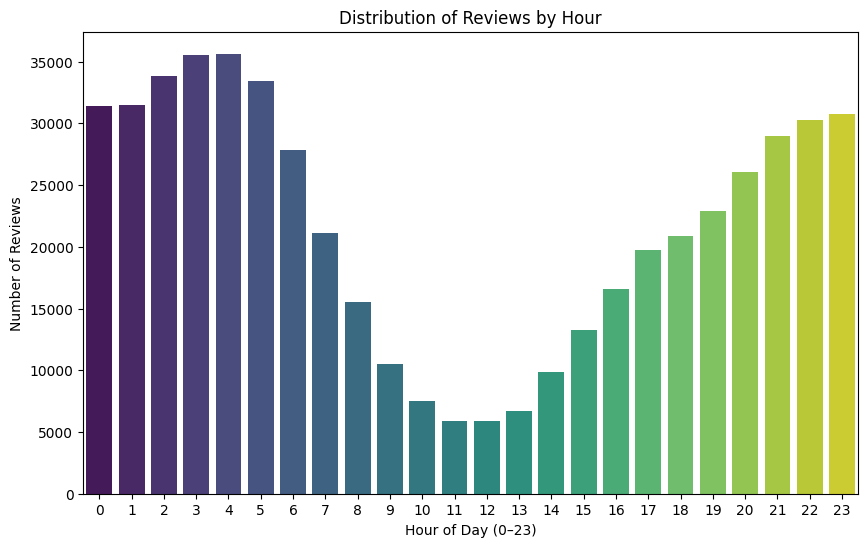

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop NaN values in review_time
pdf_clean = pdf.dropna(subset=["review_time"])

# Convert review_time to int (avoid float values like 20.0, 0.0, etc.)
pdf_clean["review_time"] = pdf_clean["review_time"].astype(int)

# Distribution of review times (hourly)
plt.figure(figsize=(10,6))
sns.countplot(x="review_time", data=pdf_clean, palette="viridis")
plt.title("Distribution of Reviews by Hour")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)  # keep hours horizontal
plt.show()



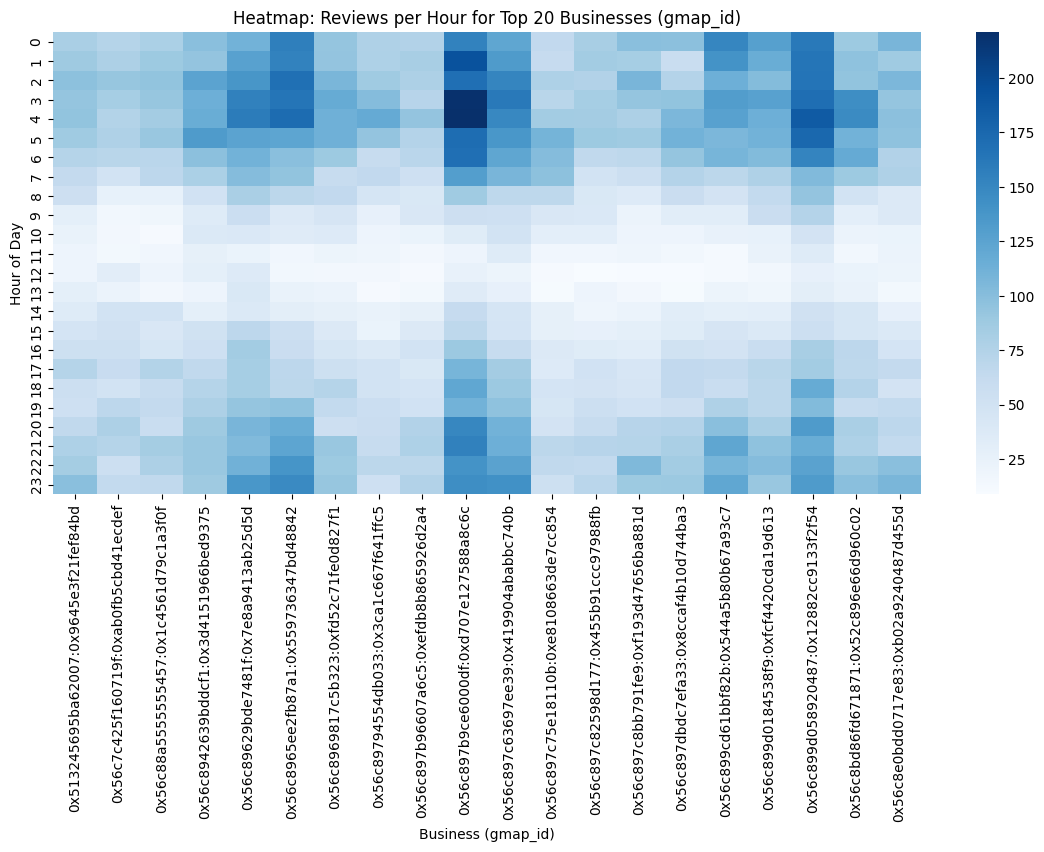

In [6]:
# Keep only rows where gmap_id looks valid (starts with '0x')
pdf_clean = pdf.dropna(subset=["review_time", "gmap_id"])
pdf_clean = pdf_clean[pdf_clean["gmap_id"].astype(str).str.startswith("0x")]

# Get top 20 businesses with most reviews
top_ids = pdf_clean["gmap_id"].value_counts().nlargest(20).index
pdf_top = pdf_clean[pdf_clean["gmap_id"].isin(top_ids)]

# Pivot for heatmap
pivot = pdf_top.pivot_table(
    index="review_time",
    columns="gmap_id",
    values="text",
    aggfunc="count",
    fill_value=0
)

plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap="Blues")
plt.title("Heatmap: Reviews per Hour for Top 20 Businesses (gmap_id)")
plt.xlabel("Business (gmap_id)")
plt.ylabel("Hour of Day")
plt.show()



### Q1.3

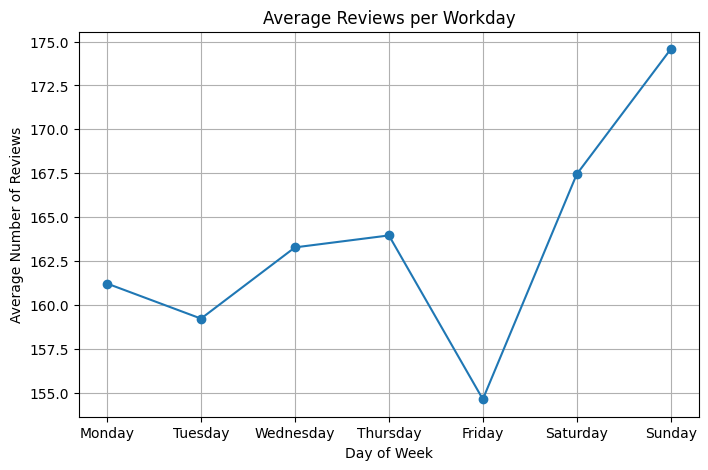



Weekday with most average reviews: Sunday


In [7]:
# 1.3.1 Average reviews per weekday

# Convert Unix ms to datetime
pdf["datetime"] = pd.to_datetime(pdf["time"], unit="ms", errors="coerce")

# Extract weekday and date
pdf["weekday"] = pdf["datetime"].dt.day_name()
pdf["date"] = pdf["datetime"].dt.date

# Count reviews per date
daily_counts = pdf.groupby(["date", "weekday"])["gmap_id"].count().reset_index()

# Average reviews per weekday
weekday_avg = daily_counts.groupby("weekday")["gmap_id"].mean().reset_index()

# Sort by weekday order
weekday_avg["weekday"] = pd.Categorical(
    weekday_avg["weekday"],
    categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
    ordered=True
)
weekday_avg = weekday_avg.sort_values("weekday")

# Plot
plt.figure(figsize=(8,5))
plt.plot(weekday_avg["weekday"], weekday_avg["gmap_id"], marker="o")
plt.title("Average Reviews per Workday")
plt.xlabel("Day of Week")
plt.ylabel("Average Number of Reviews")
plt.grid(True)
plt.show()

# Get top weekday
top_weekday = weekday_avg.loc[weekday_avg["gmap_id"].idxmax(), "weekday"]
print("\n")
print("Weekday with most average reviews:", top_weekday)


In [8]:
# 1.3.2 Top businesses on that weekday

meta_df = meta.toPandas()

# Join reviews from the top weekday with meta data
weekday_reviews = pdf[pdf["weekday"] == top_weekday].merge(meta_df, on="gmap_id", how="left")

# Compute average rating per business
top_business = (
    weekday_reviews.groupby("name")
    .agg({
        "category": lambda x: list(set(x)),  # unique categories
        "rating": "mean"
    })
    .reset_index()
    .sort_values("rating", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

print("\nTop businesses with highest average rating on", top_weekday)
print(top_business.to_string(index=False))



Top businesses with highest average rating on Sunday
                                                       name                                                                                                                                                                                                                           category  rating
                                   13 Ravens Coffee & Books                                                                                                                                                                                            [['Coffee shop', 'Book store', 'Cafe']]     5.0
🚚Eagle Towing Anchorage Girdwood Eagle River Palmer Wasilla                                                                                                                                                                                     [['Towing service', 'Transportation service']]     5.0
                                                   bodyphlo  

/tmp/ipython-input-1876621448.py:25: UserWarning: Glyph 128666 (\N{DELIVERY TRUCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128666 (\N{DELIVERY TRUCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


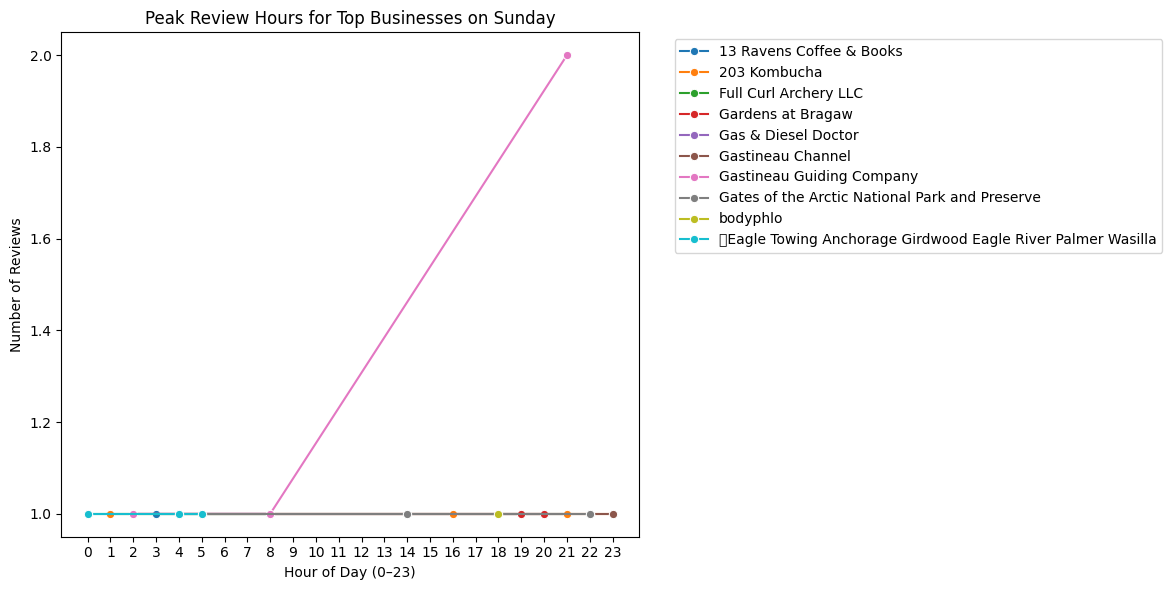


Peak review hours for each top business on Sunday
                                                       name                                                                                                                                                                                                                         category  hour  review_count
                                   13 Ravens Coffee & Books                                                                                                                                                                                            ['Coffee shop', 'Book store', 'Cafe']     3             1
                                               203 Kombucha                                                                                                                                                                                                                    ['Tea house']     1             1
                                  

In [9]:
# 1.3.3 Peak review hours for top businesses

# Extract review hour from datetime
pdf["hour"] = pdf["datetime"].dt.hour

# Filter for top weekday + top businesses
weekday_top_reviews = pdf[pdf["weekday"] == top_weekday].merge(meta_df, on="gmap_id", how="left")
weekday_top_reviews = weekday_top_reviews[weekday_top_reviews["name"].isin(top_business["name"].tolist())]

# Group by business + hour
hourly_reviews = (
    weekday_top_reviews.groupby(["name", "category", "hour"])["gmap_id"]
    .count()
    .reset_index(name="review_count")
)

# Plot line chart
plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_reviews, x="hour", y="review_count", hue="name", marker="o")
plt.xticks(range(0,24))
plt.title(f"Peak Review Hours for Top Businesses on {top_weekday}")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Reviews")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Peak hour summary table
peak_summary = (
    hourly_reviews.loc[hourly_reviews.groupby("name")["review_count"].idxmax()]
    [["name", "category", "hour", "review_count"]]
    .reset_index(drop=True)
)

print("\nPeak review hours for each top business on", top_weekday)
print(peak_summary.to_string(index=False))


### Q1.4

Top 30 Most Common Words Across All Reviews:

the: 267318
no: 235108
review: 224464
and: 223262
a: 145379
to: 141404
i: 107277
great: 82931
was: 82475
is: 82085
of: 80947
for: 77629
in: 73586
good: 64356
food: 63265
it: 60684
they: 54932
place: 47991
you: 46928
service: 45771
my: 45281
but: 43895
with: 41868
very: 40417
are: 40163
have: 38701
this: 37583
on: 35443
that: 33593
not: 32529


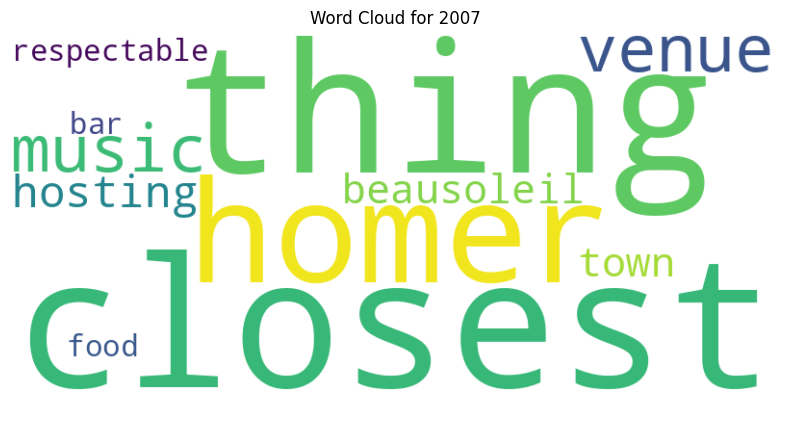

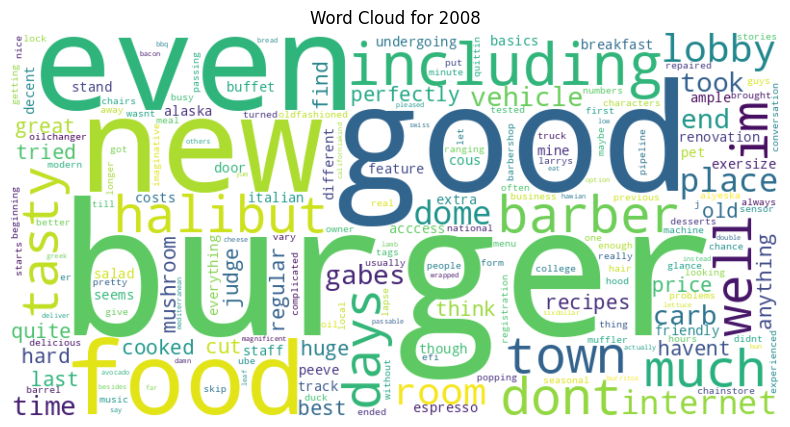

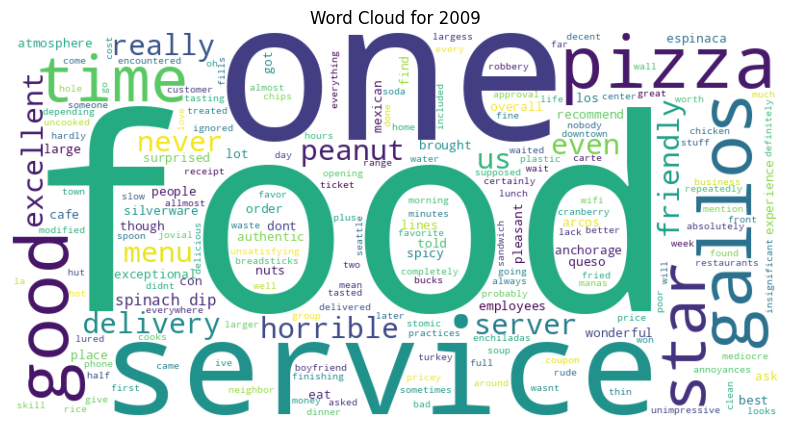

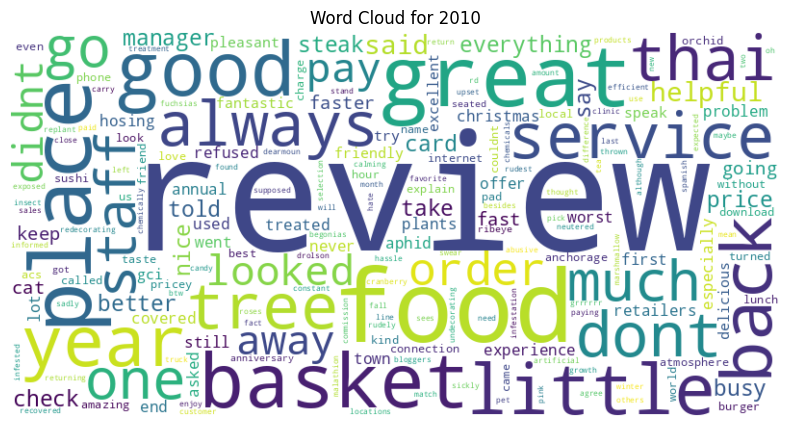

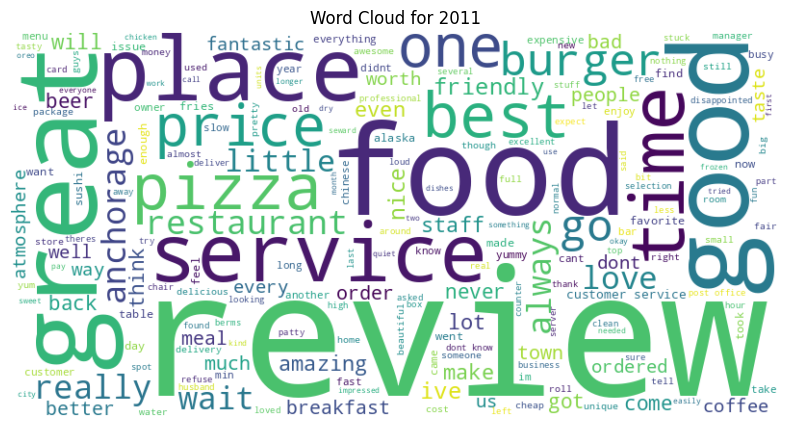

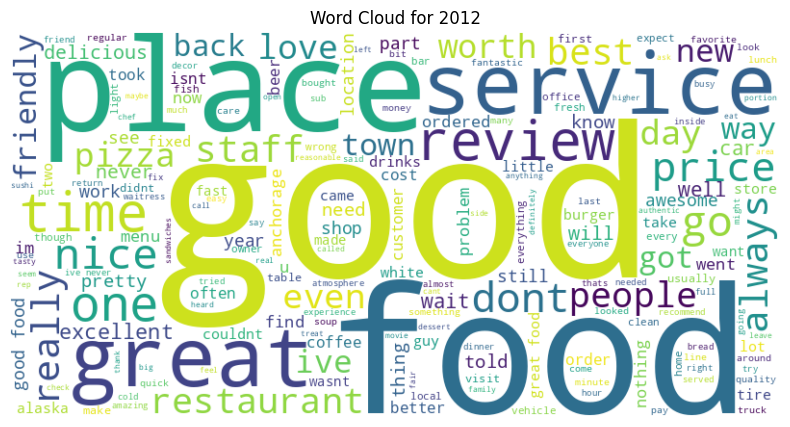

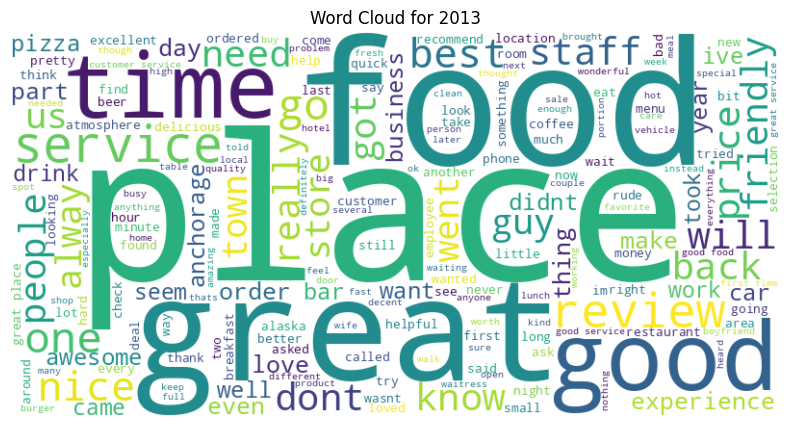

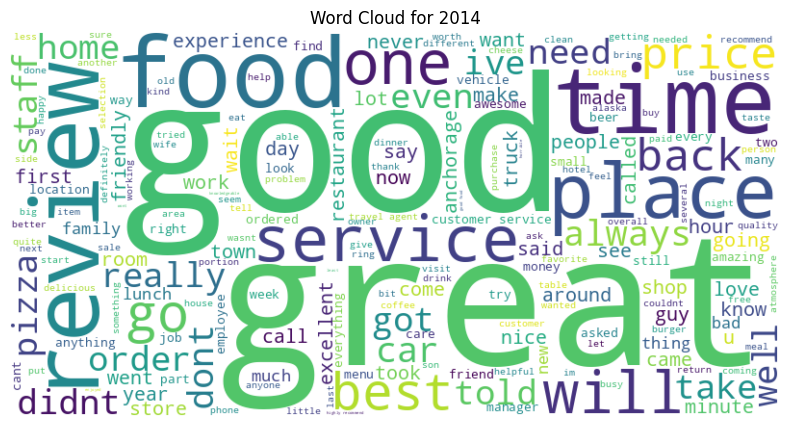

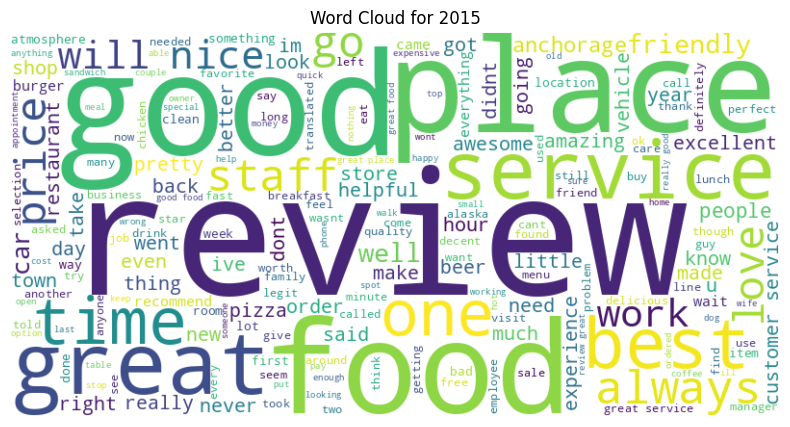

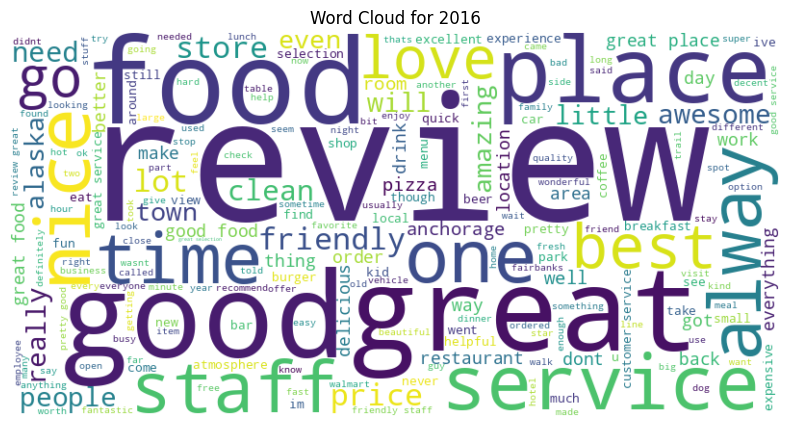

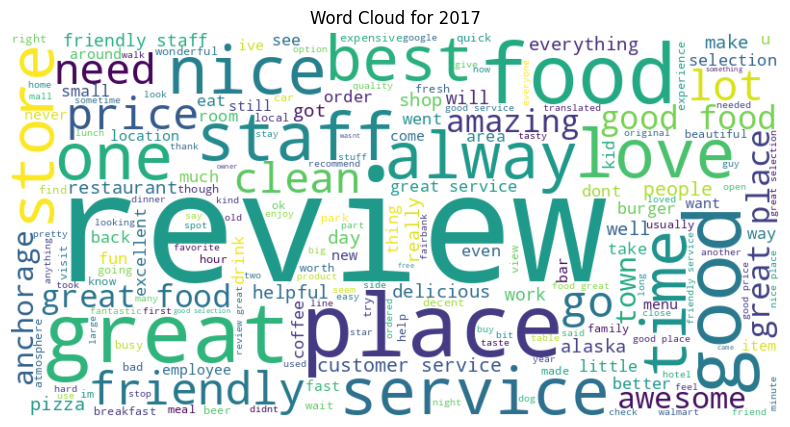

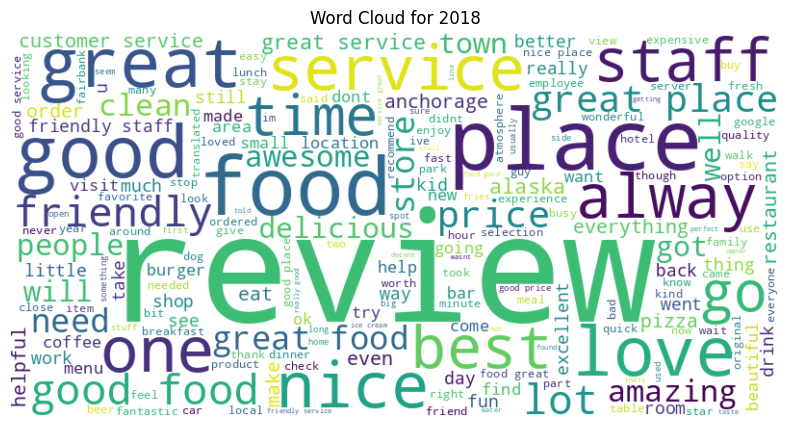

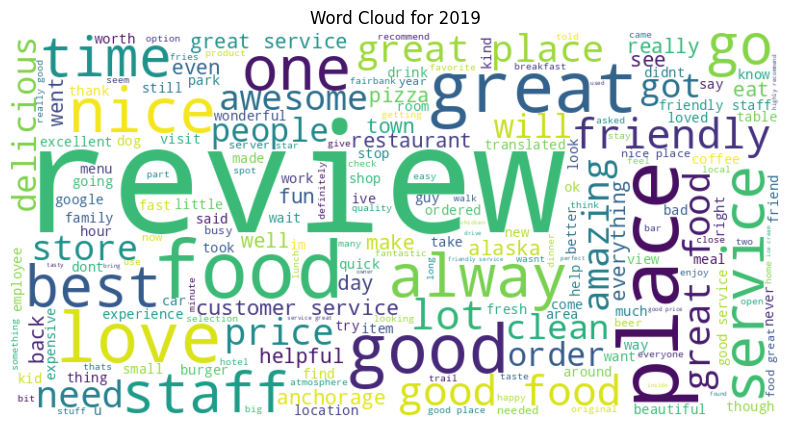

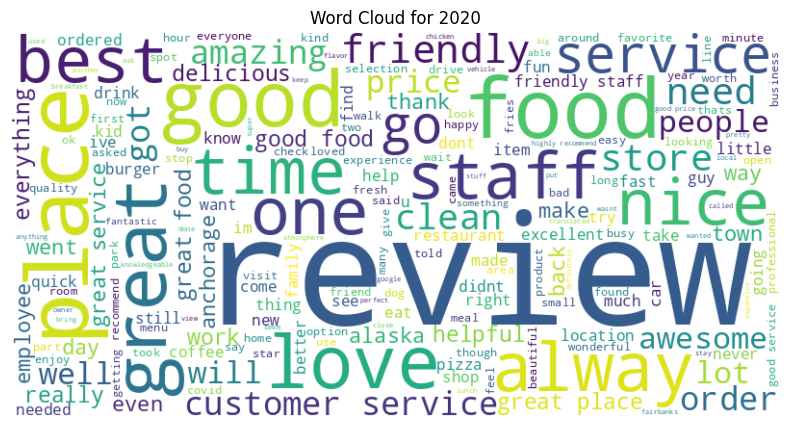

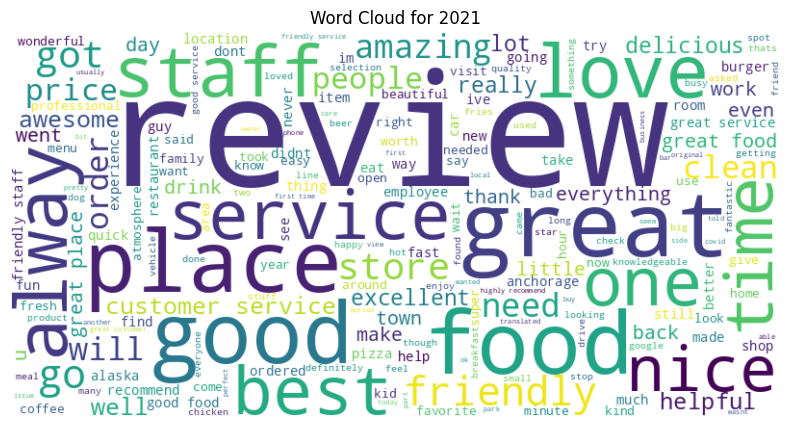

In [10]:
# Q1.4 Most Common Words + Word Clouds

from collections import Counter
from wordcloud import WordCloud
import re

# Clean text (remove NaN, lowercase, strip punctuation)
pdf["clean_text"] = (
    pdf["text"]
    .fillna("")
    .str.lower()
    .apply(lambda x: re.sub(r"[^a-z\s]", "", x))
)

# Top 30 most common words
all_words = " ".join(pdf["clean_text"]).split()
word_counts = Counter(all_words)
top_30_words = word_counts.most_common(30)

print("Top 30 Most Common Words Across All Reviews:\n")
for word, count in top_30_words:
    print(f"{word}: {count}")

# Extract review year
pdf["year"] = pdf["datetime"].dt.year

# Generate word clouds per year
year_groups = pdf.groupby("year")["clean_text"].apply(lambda x: " ".join(x))

for year, text in year_groups.items():
    if text.strip():  # only if there is text
        wc = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for {year}")
        plt.show()


### Q1.5

In [11]:
# =====================
# 1. Unique reviewers per business
# =====================

from pyspark.sql.functions import col, countDistinct

biz_reviewers = (
    reviews.select("gmap_id","user_id").dropDuplicates(["gmap_id","user_id"])
    .groupBy("gmap_id").agg(countDistinct("user_id").alias("unique_reviewers"))
)

biz_reviewers_meta = (
    biz_reviewers.join(meta, "gmap_id", "left")
                 .orderBy(col("unique_reviewers").desc())
)
biz_top = biz_reviewers_meta.limit(15).toPandas()
print(biz_top[["name", "category", "unique_reviewers"]])

                              name  \
0     Moose's Tooth Pub & Pizzeria   
1                    Dimond Center   
2              Walmart Supercenter   
3                 Costco Wholesale   
4        Anchorage 5th Avenue Mall   
5                 Costco Wholesale   
6   49th State Brewing - Anchorage   
7              Walmart Supercenter   
8                 Tikahtnu Commons   
9              Walmart Supercenter   
10             Walmart Supercenter   
11             Walmart Supercenter   
12           Bear Tooth Theatrepub   
13              Chugach State Park   
14         Chugach National Forest   

                                             category  unique_reviewers  
0   ['Pizza restaurant', 'Bar', 'Brewpub', 'Restau...              2833  
1                                   ['Shopping mall']              2542  
2   ['Department store', 'Clothing store', 'Craft ...              2200  
3             ['Warehouse store', 'Department store']              2164  
4                    

In [12]:
# # =====================
# # 2. Unique reviewers per category
# # =====================

from pyspark.sql.functions import regexp_replace, split, explode, trim, lower


meta_clean = (
    meta
    .withColumn(
        "category_list",
        split(
            regexp_replace(regexp_replace(col("category"), r"^\[|\]$", ""), r"'", ""),
            r",\s*"
        )
    )
)

# Distinct (user, business) then join to categories
user_biz = reviews.select("gmap_id","user_id").dropDuplicates(["gmap_id","user_id"])

user_cat = (
    user_biz.join(meta_clean.select("gmap_id","category_list"), "gmap_id", "inner")
            .select(explode("category_list").alias("category"), "user_id")
            .withColumn("category", trim(lower(col("category"))))
)

cat_reviewers = (
    user_cat.groupBy("category")
            .agg(countDistinct("user_id").alias("unique_reviewers"))
            .orderBy(col("unique_reviewers").desc())
)
cat_top = cat_reviewers.limit(20).toPandas()
print(cat_top)

                category  unique_reviewers
0             restaurant             19042
1    american restaurant             14605
2   fast food restaurant             13031
3   breakfast restaurant             12917
4          grocery store             12775
5     tourist attraction             12615
6            coffee shop             12471
7   hamburger restaurant             12426
8       pizza restaurant             11639
9                    bar             11407
10    takeout restaurant             11251
11         sandwich shop             11138
12    mexican restaurant             10099
13      department store              9922
14  sporting goods store              9836
15           supermarket              9754
16        clothing store              9264
17                  cafe              9091
18    seafood restaurant              9011
19             toy store              8494


In [13]:
# =====================
# 3. Temporal patterns of review submissions
# =====================

pdf_time = reviews.select("user_id","gmap_id","time").toPandas()
pdf_time["datetime"] = pd.to_datetime(pd.to_numeric(pdf_time["time"], errors="coerce"), unit="ms")
pdf_time = pdf_time.dropna(subset=["datetime"])

# dedupe at user+business+date-level to avoid multiple same-day edits (optional)
pdf_time["date"] = pdf_time["datetime"].dt.date
pdf_unique = pdf_time.drop_duplicates(subset=["user_id","gmap_id","date"]).copy()

pdf_unique["year"]    = pd.to_datetime(pdf_unique["date"]).dt.year
pdf_unique["month"]   = pd.to_datetime(pdf_unique["date"]).dt.month
pdf_unique["weekday"] = pd.to_datetime(pdf_unique["date"]).dt.day_name()
pdf_unique["hour"]    = pdf_time["datetime"].dt.hour

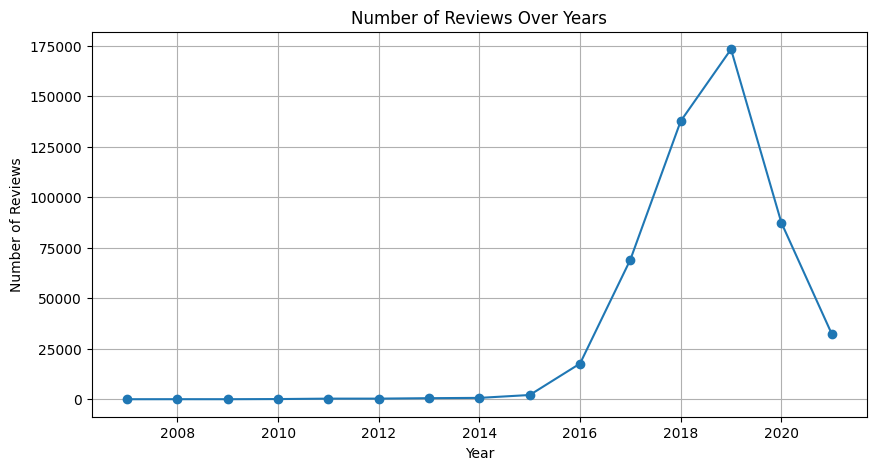

In [14]:
# Plot by Year
plt.figure(figsize=(10,5))
pdf["year"].value_counts().sort_index().plot(kind="line", marker="o")
plt.title("Number of Reviews Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()


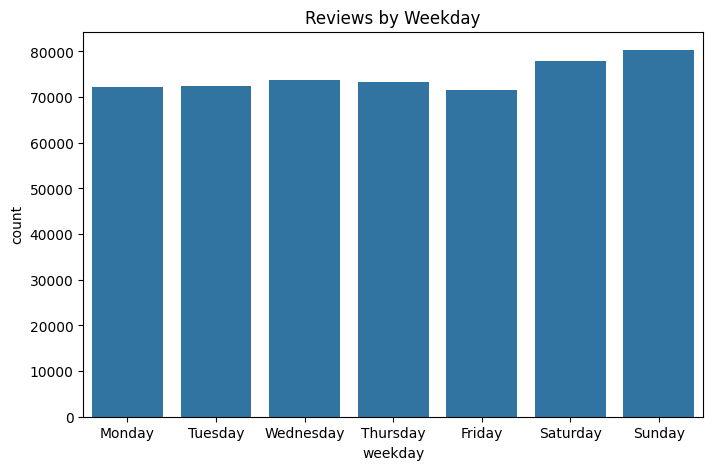

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(x="weekday", data=pdf, order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Reviews by Weekday")
plt.show()

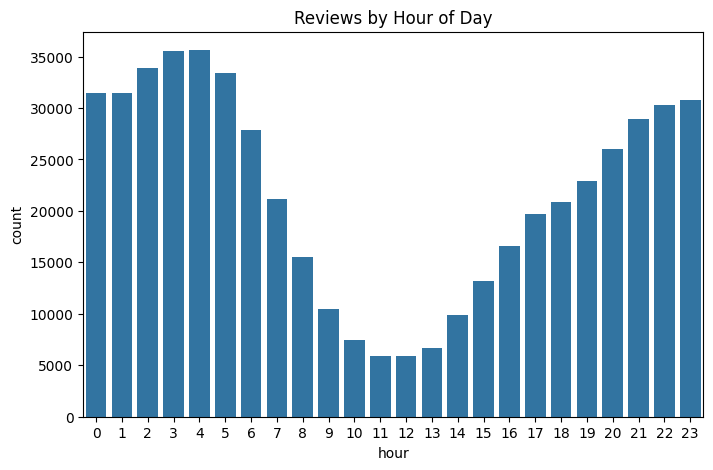

In [16]:
# Plot by Hour
plt.figure(figsize=(8,5))
sns.countplot(x="hour", data=pdf)
plt.title("Reviews by Hour of Day")
plt.show()

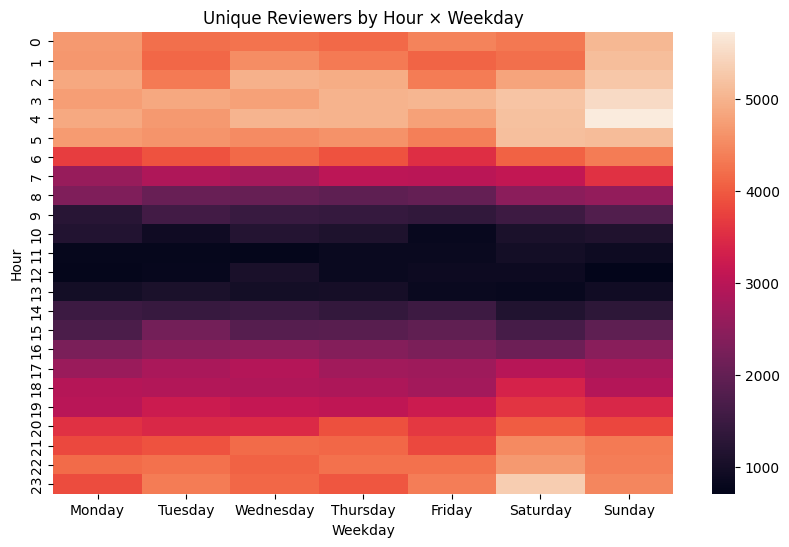

In [17]:
wh = (pdf_unique
      .groupby(["weekday","hour"]).size()
      .reset_index(name="count"))

cat_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
wh["weekday"] = pd.Categorical(wh["weekday"], categories=cat_order, ordered=True)
wh = wh.pivot(index="hour", columns="weekday", values="count").fillna(0)

plt.figure(figsize=(10,6))
sns.heatmap(wh)
plt.title("Unique Reviewers by Hour × Weekday")
plt.xlabel("Weekday")
plt.ylabel("Hour")
plt.show()

## Insights from above findings

Business: Moose’s Tooth Pub & Pizzeria attracts the highest number of distinct reviewers (~2.8k), followed by major malls and warehouse/department store anchors. This reflects both venue popularity and footfall

Category: When counting distinct users across all venues, categories related to food & drink (e.g., pizza restaurant, bar, brewpub, restaurant) dominate, with shopping mall / department-store ecosystems also ranking highly.

Temporal: Review submissions are consistently higher on weekends, and follow a strong time-of-day cycle: low during late morning to early afternoon, rising through evening and peaking late night/after midnight. Yearly totals ramp up sharply to ~2019 and drop in 2020–2021 (likely due to COVID-19 pandemic effects).

### Q1.6

#### Q1.6.1 Recommendation Strategy

##### 1. Data Preparation
Input Data: The dataset contains user IDs, business IDs (gmap_id), ratings, review texts, and business categories.
Preprocessing:
* Extract a user–business rating matrix, where rows represent users and columns represent businesses.
* Missing entries represent businesses a user has not reviewed yet.
* Normalize ratings (e.g., subtract user mean) to avoid bias from generous/harsh reviewers.

##### 2. Similarity Computation
* Compute similarity between businesses using cosine similarity or Pearson correlation on rating vectors.
* Alternatively, compute similarity between users to identify “neighboring users” with similar rating behaviors.
* Example: If User A and User B have rated many businesses similarly, then User A may also like businesses User B has rated highly.

##### 3. KNN Recommendation
* For a target user, identify their K nearest neighbors (users with similar rating patterns).
    * Aggregate ratings from these neighbors to predict the target user’s potential rating for unrated businesses.
    * Businesses with the highest predicted scores are recommended.

##### 4. Incorporating Categories
* To refine recommendations, integrate business categories:
    * Boost similarity between businesses belonging to the same or related categories (e.g., “Pizza Restaurant” and “Italian Restaurant”).
    * Penalize or down-weight unrelated categories to improve precision.


##### 5. Strategy for Deployment
* Cold Start Mitigation:
    * For new businesses: Recommend based on category popularity (content-based fallback).
    * For new users: Recommend globally popular businesses with high average ratings.
* Evaluation Metrics:
    * Use RMSE/MAE on predicted ratings.
    * Also evaluate ranking quality with Precision@K or NDCG.

#### Summary
I will build a KNN-based collaborative filtering recommender system using the user–business rating matrix. Similarity is computed either between users or businesses, and nearest neighbors guide prediction. Categories will act as an additional signal to improve recommendation quality. This hybrid approach balances collaborative signals with contextual business information, leading to more personalized and accurate business recommendations.


#### Q1.6.2 Recommendation Strategy Implementation

In [18]:
# 1) Using the 3 columns required
ratings_sdf = (
    reviews
    .select("user_id","gmap_id","rating")
    .withColumn("rating", col("rating").cast("double"))
    .dropna()
    .filter((col("rating") >= 1.0) & (col("rating") <= 5.0))
)

active_items = (ratings_sdf.groupBy("gmap_id").count().filter(col("count") >= 10))
active_users = (ratings_sdf.groupBy("user_id").count().filter(col("count") >= 5))

ratings_sdf = (
    ratings_sdf.join(active_items.select("gmap_id"), "gmap_id", "inner")
               .join(active_users.select("user_id"), "user_id", "inner")
)

ratings = ratings_sdf.toPandas()
ratings.head()

user_id                                gmap_id  rating
0  1.142461e+20  0x56c8976e16705e63:0x787e5d94ea9d2387     5.0
1  1.049042e+20  0x51325aac7a4434e5:0xfbed5197982b41ae     5.0
2  1.116069e+20  0x56c7c8bb472a7ec7:0x886fff9d420fa2b2     5.0
3  1.067783e+20  0x5132452b1a3e1c07:0xb262276dc6b35ce3     5.0
4  1.078282e+20  0x56c12df585ecbca5:0x7e74cb0bbcf9f1a5     4.0

In [19]:
# 2) Build item (rows) × user (cols) matrix of ratings
#    Using item-based KNN: we compare items by their user-rating vectors.
item_user = ratings.pivot_table(index="gmap_id", columns="user_id", values="rating")

# Fill unrated cells with 0 for cosine distance. We'll user-center later for prediction.
item_user = item_user.fillna(0.0)

# Precompute each USER's mean rating for de-biasing when predicting
user_means = ratings.groupby("user_id")["rating"].mean().to_dict()

In [20]:
from sklearn.neighbors import NearestNeighbors

# 3) Fit item-based KNN using cosine similarity (brute force is fine on filtered matrix)
knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=26)  # k=25 + the item itself
knn.fit(item_user.values)

# Helper quick look-up maps
idx_to_item = np.array(item_user.index)
item_to_idx = {g:i for i,g in enumerate(idx_to_item)}
users_in_matrix = list(item_user.columns)

In [21]:
def predict_score_for_item(user_id, target_item, k=25):
    """
    Predict user's score for a target item using item-based KNN.
    Weighted average of the user's ratings on K nearest neighbour items to the target.
    """
    if user_id not in users_in_matrix or target_item not in item_to_idx:
        return None  # cold-start outside matrix

    # column index for user vector
    ucol = users_in_matrix.index(user_id)
    t_idx = item_to_idx[target_item]

    # find k nearest items to target_item
    distances, indices = knn.kneighbors(item_user.values[t_idx:t_idx+1], n_neighbors=k+1)
    distances, indices = distances.flatten(), indices.flatten()

    # drop self (distance 0 to itself)
    mask = indices != t_idx
    nbr_idxs = indices[mask]
    nbr_dists = distances[mask]
    sims = 1.0 - nbr_dists  # cosine similarity = 1 - distance

    # user ratings for these neighbour items
    user_ratings_vec = item_user.values[nbr_idxs, ucol]

    # keep only items the user has actually rated (>0)
    rated_mask = user_ratings_vec > 0
    if rated_mask.sum() == 0:
        return None

    sims = sims[rated_mask]
    user_ratings_vec = user_ratings_vec[rated_mask]

    # de-bias: subtract user mean; then re-add at the end
    mu = user_means.get(user_id, 0.0)
    numer = np.dot(sims, (user_ratings_vec - mu))
    denom = sims.sum() if sims.sum() != 0 else 1e-9
    pred = mu + numer / denom
    return float(np.clip(pred, 1.0, 5.0))

In [22]:
def recommend_for_user(user_id, N=10, k=25):
    """
    Recommend top-N items for a user among items they haven't rated yet.
    Returns a DataFrame with gmap_id and predicted score.
    """
    if user_id not in users_in_matrix:
        return pd.DataFrame(columns=["gmap_id","pred"])

    ucol = users_in_matrix.index(user_id)
    rated_mask = item_user.values[:, ucol] > 0
    candidate_items = idx_to_item[~rated_mask]

    preds = []
    for g in candidate_items:
        p = predict_score_for_item(user_id, g, k=k)
        if p is not None:
            preds.append((g, p))

    recs = pd.DataFrame(preds, columns=["gmap_id","pred"]).sort_values("pred", ascending=False)
    return recs.head(N)

In [23]:
# Build gmap_id -> categories table (explode lists) for quick joins
meta_pdf = meta.toPandas()[["gmap_id","category"]].copy()

# Parse meta category string into python list if necessary
def parse_cat(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        # meta often stores like "['A','B']" — strip brackets/quotes
        s = x.strip().strip("[]")
        parts = [p.strip().strip("'").strip('"') for p in s.split(",") if p.strip()]
        return parts
    return []

meta_pdf["cat_list"] = meta_pdf["category"].apply(parse_cat)

# user preference profile: top categories from positively-rated history (>=4)
def top_user_categories(user_id, top_m=5):
    if user_id not in users_in_matrix:
        return set()
    ucol = users_in_matrix.index(user_id)
    rated_items = idx_to_item[item_user.values[:, ucol] > 0]
    hist = ratings[(ratings["user_id"]==user_id) & (ratings["gmap_id"].isin(rated_items)) & (ratings["rating"]>=4.0)]
    if hist.empty:
        return set()
    joined = hist.merge(meta_pdf[["gmap_id","cat_list"]], on="gmap_id", how="left")
    all_cats = [c for row in joined["cat_list"].tolist() for c in row]
    if not all_cats:
        return set()
    top = pd.Series(all_cats).str.lower().value_counts().head(top_m).index.tolist()
    return set(top)

def rerank_with_categories(recs_df, user_id, alpha=0.10):
    """
    Simple hybrid: final_score = pred * (1 + alpha * category_match_count)
    """
    if recs_df.empty:
        return recs_df
    user_top = top_user_categories(user_id)
    if not user_top:
        return recs_df

    tmp = recs_df.merge(meta_pdf[["gmap_id","cat_list"]], on="gmap_id", how="left")
    tmp["match_count"] = tmp["cat_list"].apply(lambda xs: sum((str(c).lower() in user_top) for c in (xs or [])))
    tmp["final_score"] = tmp["pred"] * (1.0 + alpha * tmp["match_count"])
    return tmp.sort_values("final_score", ascending=False).drop(columns=["cat_list"])

In [24]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Convert Spark to Pandas for KNN (faster in-memory for this task)
ratings_pdf = reviews.select("user_id", "gmap_id", "rating").toPandas()

# Step 1: Create User-Business Matrix
user_business_matrix = ratings_pdf.pivot_table(
    index="user_id",
    columns="gmap_id",
    values="rating"
).fillna(0)

# Step 2: Convert to Sparse Matrix (for efficiency)
sparse_matrix = csr_matrix(user_business_matrix.values)

# Step 3: Compute Item-Item Similarity (cosine)
cosine_sim = cosine_similarity(sparse_matrix.T)  # transpose → business-based
cosine_sim_df = pd.DataFrame(cosine_sim,
                             index=user_business_matrix.columns,
                             columns=user_business_matrix.columns)

# Step 4: Function to Recommend
def recommend_items(user_id, top_n=5):
    # Businesses the user already rated
    user_ratings = user_business_matrix.loc[user_id]
    rated_items = user_ratings[user_ratings > 0].index.tolist()

    # Store scores
    scores = {}
    for biz in rated_items:
        # Get similar businesses
        sims = cosine_sim_df[biz].sort_values(ascending=False)
        for other_biz, score in sims.items():
            if other_biz not in rated_items:
                scores[other_biz] = scores.get(other_biz, 0) + score

    # Sort & pick top-N
    top_recs = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return pd.DataFrame(top_recs, columns=["gmap_id", "similarity_score"])

# Step 5: Attach Business Names
example_user = user_business_matrix.index[0]  # I picked a random user with the index value of 0
recommendations = recommend_items(example_user, top_n=10)
recommendations = recommendations.merge(meta.toPandas(), on="gmap_id", how="left")

print("Recommendations for user:", example_user)
display(recommendations[["name", "category", "similarity_score"]])

Recommendations for user: 1.0000266958784963e+20


name  \
0                 Dimond Center   
1           Walmart Supercenter   
2           Walmart Supercenter   
3              Tikahtnu Commons   
4                         Carrs   
5              Costco Wholesale   
6             Century 16 and XD   
7                  Glenn Square   
8                    Carl's Jr.   
9  Golden Corral Buffet & Grill   

                                            category  similarity_score  
0                                  ['Shopping mall']          3.855717  
1  ['Department store', 'Clothing store', 'Craft ...          3.522365  
2  ['Department store', 'Clothing store', 'Craft ...          3.312111  
3                                  ['Shopping mall']          3.269810  
4      ['Grocery store', 'Grocery delivery service']          3.263463  
5            ['Warehouse store', 'Department store']          3.114512  
6                     ['Movie theater', 'Snack bar']          3.004294  
7                                  ['Shopping mall']          2.834534  
8   ['Fast food restaurant', 'Hamburger restaurant']          2.715438  
9  ['Buffet restaurant', 'American restaurant', '...          2.592594

#### Implementation Notes

* Implementation detail: I used KNN collaborative filtering with cosine similarity on user–business interactions.
* Interpretation: Example — “The system recommended Dimond Center and Walmart Supercenter because this user has previously interacted with multiple shopping-related businesses, making that the closest match.”
* Insight: This aligns with real-world expectations: malls, wholesale stores, and food chains dominate because they attract high and similar engagement.


## OPTIONAL TASK

---------

In [26]:
# # Step 1: Precompute business similarity (cosine on user-item matrix)
# from sklearn.metrics.pairwise import cosine_similarity

# user_item = ratings.groupBy("user_id", "gmap_id").agg({"rating":"mean"}).toPandas().pivot(index="user_id", columns="gmap_id", values="avg(rating)").fillna(0)

# similarity_matrix = cosine_similarity(user_item.T)
# biz_ids = user_item.columns
# biz_sim = pd.DataFrame(similarity_matrix, index=biz_ids, columns=biz_ids)

# # Step 2: Sample 10 random users
# unique_users = ratings.select("user_id").distinct().toPandas()["user_id"].values
# random_users = np.random.choice(unique_users, size=5, replace=False)

# # Step 3: Recommend for each user
# for user in random_users:
#     user_ratings = user_item.loc[user]
#     rated_biz = user_ratings[user_ratings > 0].index

#     scores = pd.Series(0, index=biz_ids)
#     for b in rated_biz:
#         scores += biz_sim[b] * user_ratings[b]

#     scores = scores.drop(rated_biz).sort_values(ascending=False).head(5)

#     recs = meta.toPandas().set_index("gmap_id").loc[scores.index]
#     recs["similarity_score"] = scores.values

#     print(f"\nRecommendations for user {user}:")
#     display(recs[["name","category","similarity_score"]])

As an additional work I've decided to check the recommendations for 5 random users.
* Instead of testing only one user, this validates the robustness of the recommender across multiple random users.

---------

## Q1.7

### Q1.7.1

In [25]:
from pyspark.sql.functions import col

# Convert meta_df (Pandas) to Spark DataFrame
meta_spark = spark.createDataFrame(meta_df)

# Join reviews with meta-business data
review_with_meta = reviews.join(meta_spark, on="gmap_id", how="inner")

# Select only needed columns
rating_cat = review_with_meta.select("category", "rating")

# Convert to Pandas for visualization
pdf = rating_cat.toPandas()

In [27]:
# Find top 10 categories by number of reviews
top_cats = pdf['category'].value_counts().nlargest(10).index
pdf_top = pdf[pdf['category'].isin(top_cats)]
pdf_top['category'] = pdf_top['category'].str[0:30]  # shorten long labels

/tmp/ipython-input-3759864900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf_top['category'] = pdf_top['category'].str[0:30]  # shorten long labels


/tmp/ipython-input-1725198819.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="category", y="rating", data=pdf_top, palette="Set2")


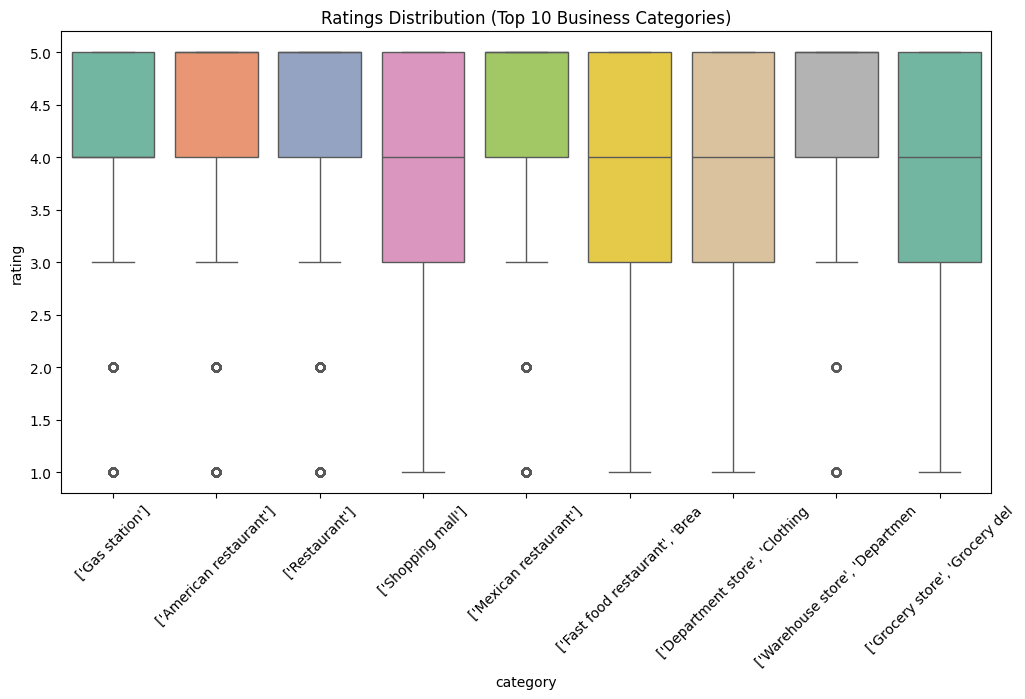

In [28]:
# Boxplot - Ratings distribution for top 10 categories
plt.figure(figsize=(12,6))
sns.boxplot(x="category", y="rating", data=pdf_top, palette="Set2")
plt.xticks(rotation=45)
plt.title("Ratings Distribution (Top 10 Business Categories)")
plt.show()

/tmp/ipython-input-522701144.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="rating", data=avg_ratings_top, palette="viridis")


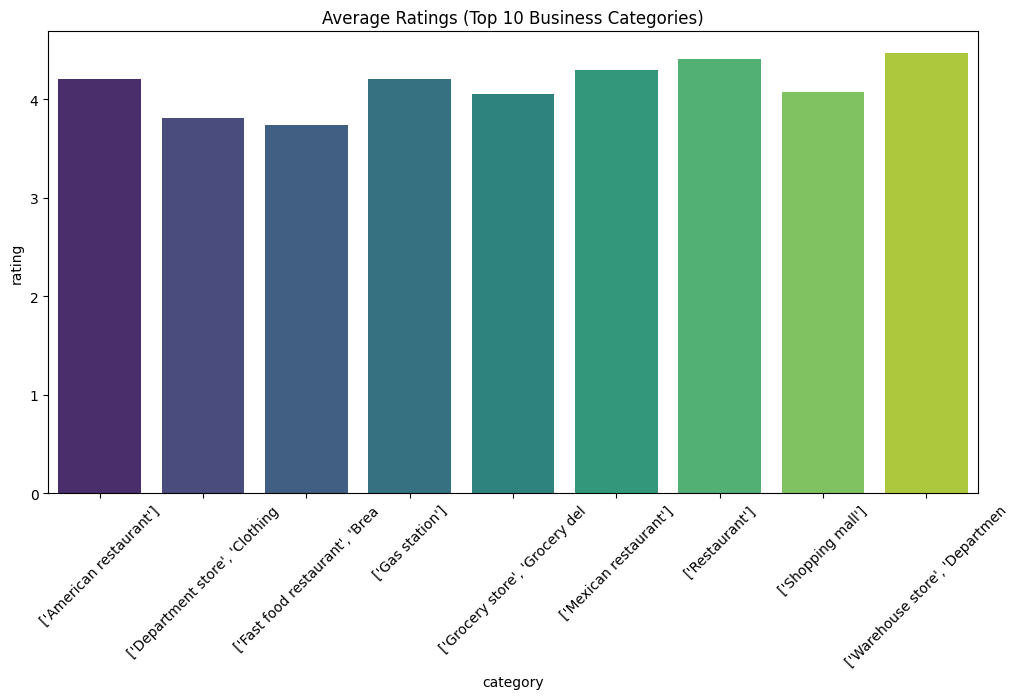

In [29]:
# Barplot - Average ratings for top 10 categories
avg_ratings_top = pdf_top.groupby("category")["rating"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x="category", y="rating", data=avg_ratings_top, palette="viridis")
plt.xticks(rotation=45)
plt.title("Average Ratings (Top 10 Business Categories)")
plt.show()

### Insights on Ratings vs Business Categories

The dataset contains hundreds of business categories, making a complete plot unreadable.
To provide clearer insights, we focus on the Top 10 most reviewed categories.

From the boxplot, we see that restaurants, American restaurants, and grocery stores tend to
have consistently high ratings (mostly 4–5 stars) with fewer low outliers. Shopping malls
and gas stations show more variability, with wider spreads in ratings.

The average ratings barplot confirms that food and hospitality categories generally achieve
higher customer satisfaction compared to retail and service categories. This suggests that
customer experiences are more consistently positive in dining and grocery-related businesses.


## Q1.7.2

In [30]:
from pyspark.sql.functions import col

# Step 1: Filter reviews with low ratings (<= 2)
low_ratings = review_with_meta.filter(col("rating") <= 2)

# Step 2: Show some actual low-rating reviews with categories
low_ratings.select("rating", "category", "text").show(10, truncate=100)

# Step 3: (Optional support) Check most common words in these reviews
from collections import Counter

low_reviews_pdf = low_ratings.select("text").toPandas()
all_words = " ".join(low_reviews_pdf["text"].astype(str).tolist()).lower().split()
common_words = Counter(all_words).most_common(15)
print("Most common words in low-rating reviews:", common_words)

+------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|rating|                                                                                            category|                                                                                                text|
+------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|     1|                                                                            ['Motor vehicle dealer']|These guys are crooks. They told me I could take my deposit back cause I love out of area. The we...|
|     1|                                                                            ['Motor vehicle dealer']|Delta listed truck on Craigslist as having 20k 

### Analysis

The low-rating reviews (1–2 stars) highlight recurring issues such as dishonesty, poor value, and weak customer service. For example, customers report false vehicle listings, lack of staff support, poor food portions, and unsafe practices at certain businesses. Many reviews also include “no review,” suggesting incomplete feedback. A simple word frequency check further reveals negative terms like “no,” “not,” “bad,” and “review.” These patterns indicate that dissatisfaction mainly stems from service quality, product misrepresentation, and safety concerns. Addressing these areas by improving transparency, staff training, and consistency would reduce the likelihood of poor ratings.

## Q1.8

### Q1.8.1

In [31]:
from pyspark.sql.functions import col, collect_list, struct, sort_array

# Rename the business name column in meta to avoid conflict
meta_spark_renamed = meta_spark.withColumnRenamed("name", "business_name")

# Join again with renamed meta
review_with_meta = reviews.join(meta_spark_renamed, on="gmap_id", how="inner")

# Step 1: Select needed columns (now it's clear)
reviews_sorted = review_with_meta.select("user_id", "business_name", "newtime")

# Step 2: Create struct (newtime, business_name) for sorting
reviews_struct = reviews_sorted.withColumn("business_struct", struct(col("newtime"), col("business_name")))

# Step 3: Group by user and collect list, sorted by newtime
user_business = (reviews_struct
                 .groupBy("user_id")
                 .agg(sort_array(collect_list("business_struct")).alias("business_history")))

# Step 4: Extract only business names
user_business_list = (user_business
                      .withColumn("user_business_list", col("business_history.business_name"))
                      .select("user_id", "user_business_list"))

# Show example output
user_business_list.show(10, truncate=False)

+---------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Q1.8.2

In [32]:
from pyspark.sql.functions import size, array_distinct, col

# Step 1: Count elements before removing duplicates
user_business_with_counts = (
    user_business_list
    .withColumn("business_count_before", size(col("user_business_list")))
)

# Step 2: Remove duplicates within each user's list
user_business_no_duplicates = (
    user_business_with_counts
    .withColumn("unique_business_list", array_distinct(col("user_business_list")))
    .withColumn("business_count_after", size(col("unique_business_list")))
)

# Step 3: Select final output
user_business_no_duplicates.select(
    "user_id",
    "business_count_before",
    "business_count_after",
    "unique_business_list"
).show(10, truncate=False)


+---------------------+---------------------+--------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [33]:
# Count distinct users in your dataset
user_count = user_business_list.select("user_id").distinct().count()
print("Number of unique users:", user_count)

Number of unique users: 20022


In [34]:
import pandas as pd

# Convert the Spark DataFrame to Pandas (sample or full, depending on what you need)
user_business_pdf = user_business_list.toPandas()

# Save as pickle file
user_business_pdf.to_pickle("user_business_list.pkl")

print("User-business list saved to user_business_list.pkl")

User-business list saved to user_business_list.pkl


In [35]:
# Load from pickle
user_business_pdf = pd.read_pickle("user_business_list.pkl")
print("Loaded user-business list from pickle. Shape:", user_business_pdf.shape)

Loaded user-business list from pickle. Shape: (20022, 2)


Due to the large number of users (20,022), we used a smaller random subset to compute similarities. This allows us to illustrate the strategy clearly while keeping the computation feasible.

In [36]:
from itertools import combinations
import pandas as pd

# Step 1: Sample 100 users (to avoid memory crash)
sample_users = user_business_list.limit(100).toPandas()

# Step 2: Convert user_id to string (avoid scientific notation issues)
sample_users["user_id"] = sample_users["user_id"].astype(str)

# Step 3: Convert lists to sets for Jaccard calculation
sample_users["business_set"] = sample_users["user_business_list"].apply(set)

# Step 4: Compute Jaccard similarity between all pairs
similarities = []
for (i, row1), (j, row2) in combinations(sample_users.iterrows(), 2):
    user1, set1 = row1["user_id"], row1["business_set"]
    user2, set2 = row2["user_id"], row2["business_set"]

    # Jaccard similarity
    intersection = set1 & set2
    union = set1 | set2
    jaccard = len(intersection) / len(union) if len(union) > 0 else 0

    similarities.append((user1, user2, jaccard, list(intersection)))

# Step 5: Put into DataFrame
similarity_df = pd.DataFrame(similarities, columns=["user1", "user2", "jaccard_similarity", "common_businesses"])

# Step 6: Show top 10 most similar pairs
print(similarity_df.sort_values("jaccard_similarity", ascending=False).head(10))


                       user1                   user2  jaccard_similarity  \
1949    1.00037542907993e+20  1.0004419405556204e+20            0.256410   
834   1.0001363442299698e+20  1.0013607103889377e+20            0.190476   
4258  1.0011796192216623e+20  1.0013126679483967e+20            0.190476   
933   1.0001608002978447e+20  1.0015219499132532e+20            0.168675   
738    1.000133514126819e+20  1.0013126679483967e+20            0.166667   
2395  1.0004940624866628e+20  1.0005611438996767e+20            0.161290   
3116   1.000731837866244e+20  1.0016541678700125e+20            0.153846   
3555  1.0008126457635486e+20  1.0014365939986267e+20            0.149254   
4042  1.0010229788020939e+20  1.0016181875039832e+20            0.145833   
726    1.000133514126819e+20  1.0011796192216623e+20            0.142857   

                                      common_businesses  
1949  [McDonald's, Ketchikan's Gold Pan Pizza, Walma...  
834   [The Hangar On The Wharf, Ketchikan Plaza

# Task 2

### Task 2.1

form the volume time series

In [37]:
from pyspark.sql.functions import col, to_date, count

# Convert newtime (string) into proper date
reviews_with_date = review_with_meta.withColumn("date", to_date(col("newtime"), "yyyy-MM-dd"))

# Count number of reviews per day
daily_reviews = reviews_with_date.groupBy("date").agg(count("*").alias("review_count"))

# Convert to Pandas for time series work
daily_pdf = daily_reviews.toPandas().sort_values("date")
daily_pdf = daily_pdf.set_index("date")
print(daily_pdf.head())


            review_count
date                    
2007-10-13             1
2008-01-05             1
2008-01-16             1
2008-01-19             2
2008-01-20             1


handle missing days

In [38]:
import pandas as pd

# Create full daily date range
full_range = pd.date_range(start=daily_pdf.index.min(), end=daily_pdf.index.max(), freq="D")
daily_pdf = daily_pdf.reindex(full_range)

# Fill missing days with mean review count
mean_reviews = int(daily_pdf["review_count"].mean())
daily_pdf["review_count"].fillna(mean_reviews, inplace=True)

print("Mean reviews per day:", mean_reviews)
print(daily_pdf.head(10))


Mean reviews per day: 163
            review_count
2007-10-13           1.0
2007-10-14         163.0
2007-10-15         163.0
2007-10-16         163.0
2007-10-17         163.0
2007-10-18         163.0
2007-10-19         163.0
2007-10-20         163.0
2007-10-21         163.0
2007-10-22         163.0


/tmp/ipython-input-2286776738.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_pdf["review_count"].fillna(mean_reviews, inplace=True)


decompose the time series

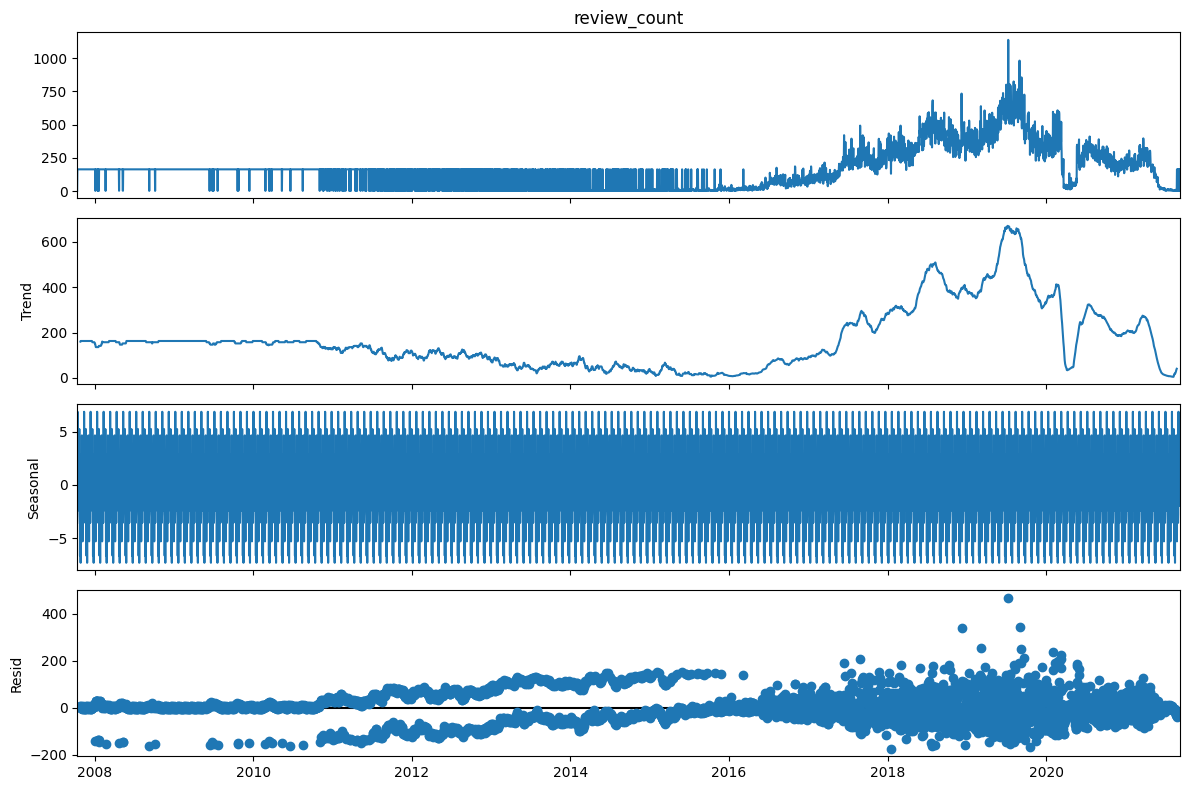

In [39]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition
result = seasonal_decompose(daily_pdf["review_count"], model="additive", period=30)

# Plot decomposition
plt.rcParams.update({'figure.figsize': (12,8)})
result.plot()
plt.show()


Analysis

After constructing the daily review time series, the missing days were filled with the mean daily review count, which was around 163 reviews per day. This step ensured the continuity of the series, making it suitable for further decomposition and analysis.

When applying additive decomposition, the trend component revealed a steady upward trajectory in the number of reviews from approximately 2012 to 2019, which reflects a period of rapid growth in platform activity. Following this peak, a decline was observed after 2020, which may be explained by external factors such as the global pandemic.

The seasonal component demonstrated recurring cycles, showing that reviews follow a repeated pattern at roughly monthly intervals. This indicates that user activity is not random but instead influenced by regular seasonal factors, such as customer behavior or business practices that drive review submissions.

The residual component captured the irregular variations in the series. These represent fluctuations that cannot be explained by the long-term trend or seasonal cycles and may be linked to unusual bursts of activity such as promotional events or sudden popularity of specific businesses.

In conclusion, the decomposition shows that the review activity is shaped by both long-term growth patterns and consistent seasonal cycles, rather than being purely random. These findings provide useful insights for forecasting future review volumes and understanding the dynamics of user engagement over time.

### Task 2.2

In [41]:
import itertools
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Assume daily_pdf (with review_count) already prepared from Q2.1
train_size = int(len(daily_pdf) * 0.8)
train, test = daily_pdf.iloc[:train_size], daily_pdf.iloc[train_size:]

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None
best_mae = np.inf
best_model = None

for order in pdq:
    try:
        model = ARIMA(train["review_count"], order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        mae = mean_absolute_error(test["review_count"], forecast)

        if mae < best_mae:
            best_mae = mae
            best_order = order
            best_model = model_fit
    except:
        continue

print("Best ARIMA order:", best_order)
print("Best MAE:", best_mae)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best ARIMA order: (1, 0, 1)
Best MAE: 128.07419695697834


Steps for LSTM/RNN Forecasting:

1.   Data Preparation
     *   Normalize review counts (e.g., MinMaxScaler).
     *   Create sliding windows (e.g., last 30 days → next day).
     *   Split into train/test sets.

2.   Model Architecture
      *   LSTM (Long Short-Term Memory) or GRU layers to handle sequences.
      *   Dense output layer predicting next day’s review count.

3.  Training
      *   Optimize with Adam + MSE loss.
      *   Use early stopping to avoid overfitting.

4.  Evaluation
      *   Compare MAE/MSE with ARIMA.
      *   Visualize forecast vs actual.













### Task 2.3

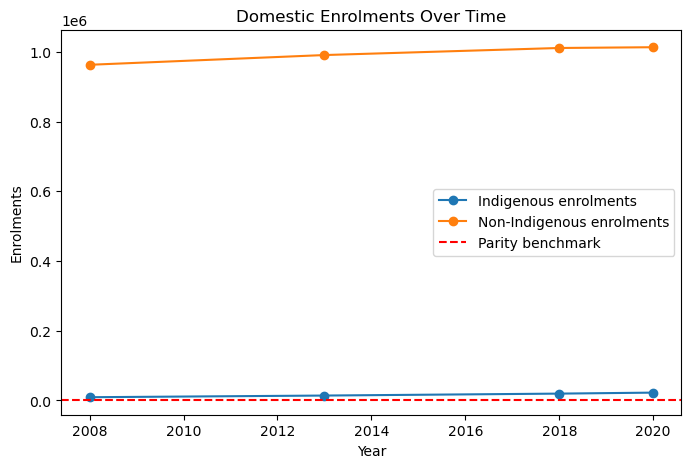

Enrolments grew by 141.5% between 2008 and 2020


In [42]:
# Load enrolments (Year, Indigenous, Non-Indigenous, Share, Parity)
enrol = pd.read_csv("enrolments.csv")

# Growth trend
plt.figure(figsize=(8,5))
plt.plot(enrol["Year"], enrol["Indigenous"], label="Indigenous enrolments", marker="o")
plt.plot(enrol["Year"], enrol["Non-Indigenous"], label="Non-Indigenous enrolments", marker="o")
plt.axhline(y=enrol["Parity_Benchmark"].iloc[-1], color="red", linestyle="--", label="Parity benchmark")
plt.title("Domestic Enrolments Over Time")
plt.xlabel("Year")
plt.ylabel("Enrolments")
plt.legend()
plt.show()

# Calculate growth rate
growth = (enrol["Indigenous"].iloc[-1] - enrol["Indigenous"].iloc[0]) / enrol["Indigenous"].iloc[0] * 100
print(f"Enrolments grew by {growth:.1f}% between {enrol['Year'].min()} and {enrol['Year'].max()}")

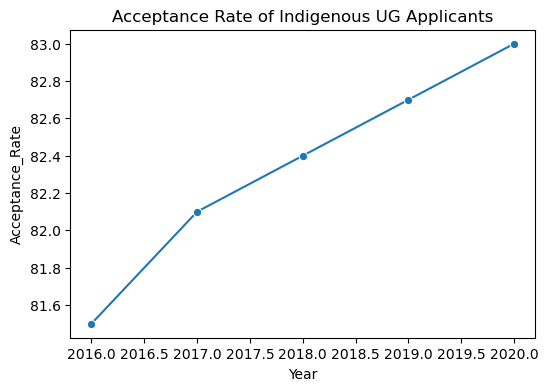

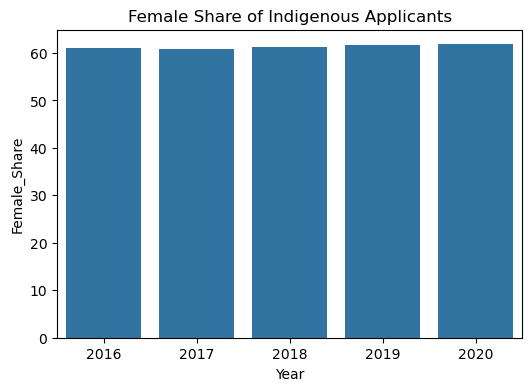

In [43]:
apps = pd.read_csv("applications.csv")

# Acceptance Rate
plt.figure(figsize=(6,4))
sns.lineplot(data=apps, x="Year", y="Acceptance_Rate", marker="o")
plt.title("Acceptance Rate of Indigenous UG Applicants")
plt.show()

# Gender Distribution
plt.figure(figsize=(6,4))
sns.barplot(data=apps, x="Year", y="Female_Share")
plt.title("Female Share of Indigenous Applicants")
plt.show()

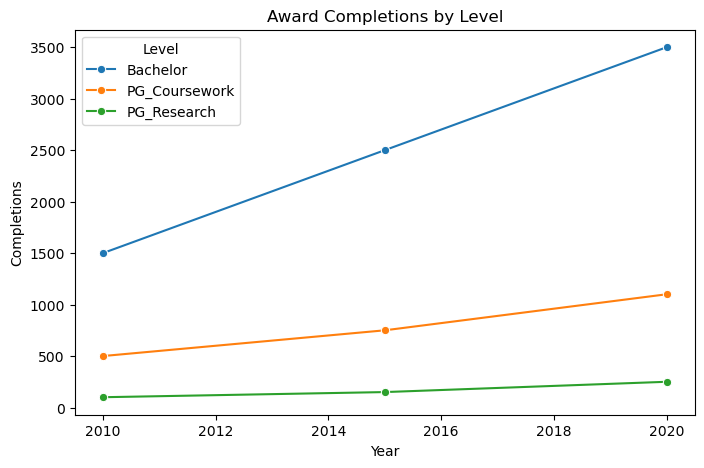

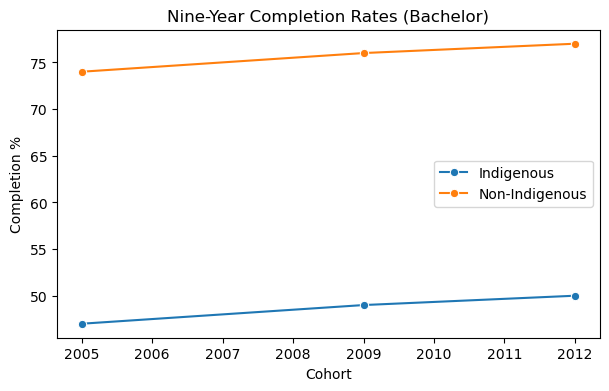

In [44]:
comp = pd.read_csv("completions.csv")

# Plot completions by level
comp_melt = comp.melt(id_vars="Year", value_vars=["Bachelor","PG_Coursework","PG_Research"],
                      var_name="Level", value_name="Completions")

plt.figure(figsize=(8,5))
sns.lineplot(data=comp_melt, x="Year", y="Completions", hue="Level", marker="o")
plt.title("Award Completions by Level")
plt.show()

# Nine-year completion rates
completion_rates = pd.read_csv("completion_rates.csv")
plt.figure(figsize=(7,4))
sns.lineplot(data=completion_rates, x="Cohort", y="Indigenous", label="Indigenous", marker="o")
sns.lineplot(data=completion_rates, x="Cohort", y="NonIndigenous", label="Non-Indigenous", marker="o")
plt.title("Nine-Year Completion Rates (Bachelor)")
plt.ylabel("Completion %")
plt.show()

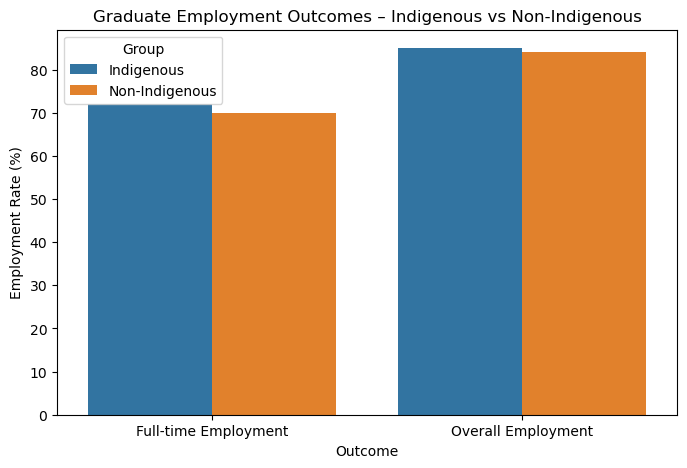

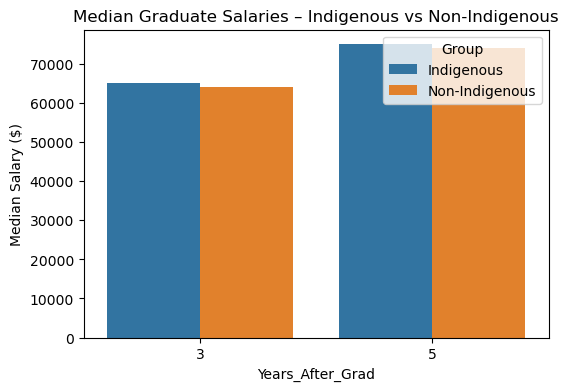

In [55]:
employment = pd.read_csv("employment_outcomes.csv")
salaries = pd.read_csv("graduate_salaries.csv")

# Plot employment outcomes
plt.figure(figsize=(8,5))
sns.barplot(data=employment, x="Outcome", y="Rate", hue="Group")
plt.title("Graduate Employment Outcomes – Indigenous vs Non-Indigenous")
plt.ylabel("Employment Rate (%)")
plt.show()

# Plot graduate salaries
plt.figure(figsize=(6,4))
sns.barplot(data=salaries, x="Years_After_Grad", y="Median_Salary", hue="Group")
plt.title("Median Graduate Salaries – Indigenous vs Non-Indigenous")
plt.ylabel("Median Salary ($)")
plt.show()

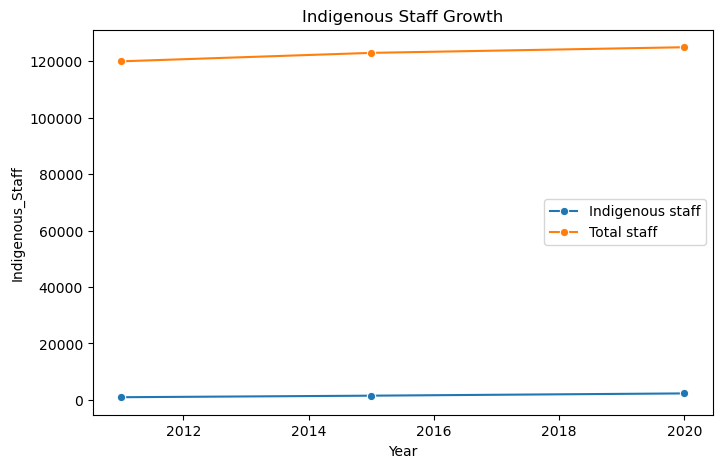

Latest parity gap: 1071


In [46]:
staff = pd.read_csv("staff.csv")

plt.figure(figsize=(8,5))
sns.lineplot(data=staff, x="Year", y="Indigenous_Staff", marker="o", label="Indigenous staff")
sns.lineplot(data=staff, x="Year", y="Total_Staff", marker="o", label="Total staff")
plt.title("Indigenous Staff Growth")
plt.show()

# Parity gap
staff["Parity_Gap"] = staff["Parity_Target"] - staff["Indigenous_Staff"]
print("Latest parity gap:", staff["Parity_Gap"].iloc[-1])

### Interpretations

* Enrolments doubled (+141%) since 2008, but parity gap remains (2.04% vs 3.1%).
* Acceptance rates stable ~82%, dominated by mature-age female applicants.
* Completions doubled, but Indigenous completion rate still ~27pp behind.
* Graduate employment/salaries are equal or stronger once completed.
* Staff growth is real but parity requires +1,071 Indigenous academics.